In [1]:
# Francisco Dominguez Mateos
# 06/08/2020
# Laplace aproximatoin with jax
# from: https://anguswilliams91.github.io/statistics/computing/jax/

In [2]:
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad

from jax import hessian
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import t

import matplotlib.pyplot as plt

# Straightforward intro to jax

In [3]:
def logistic(x):
    # logistic function
    return (1. + np.exp(-x)) ** -1.0

# differentiate with jax!
grad_logistic = grad(logistic)

print(logistic(0.0))
print(grad_logistic(0.0))

0.5
0.25


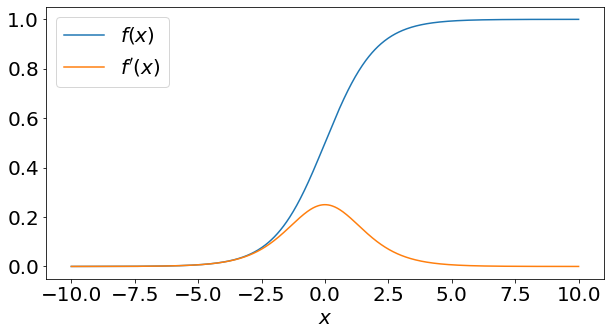

In [4]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 20

vectorised_grad_logistic = vmap(grad_logistic)

x = np.linspace(-10.0, 10.0, 1000)
fig, ax = plt.subplots()
ax.plot(x, logistic(x), label="$f(x)$")
ax.plot(x, vectorised_grad_logistic(x), label="$f'(x)$")
_ = ax.legend()
_ = ax.set_xlabel("$x$")

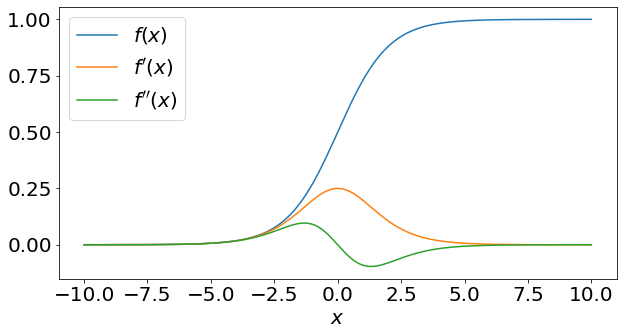

In [5]:
second_order_grad_logistic = vmap(grad(grad(logistic)))

x = np.linspace(-10.0, 10.0, 1000)
fig, ax = plt.subplots()
ax.plot(x, logistic(x), label="$f(x)$")
ax.plot(x, vectorised_grad_logistic(x), label="$f'(x)$")
ax.plot(x, second_order_grad_logistic(x), label="$f''(x)$")
_ = ax.legend()
_ = ax.set_xlabel("$x$")

In [6]:
@jit
def jit_logistic(x):
    # logistic function
    return (1. + np.exp(-x)) ** -1.0

@jit
def jit_grad_logistic(x):
    # compile the gradient as well
    return grad(logistic)(x)

In [7]:
%%timeit
logistic(0.0)

480 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
jit_logistic(0.0)

173 µs ± 6.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
grad_logistic(0.0)

3.23 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
jit_grad_logistic(0.0)

172 µs ± 2.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Laplace approximation

Given a probability distribution $p(\theta|D)$ and its log function $f(\theta)=log p(\theta|D)$. We need to aproximate it with a Gaussian. Laplace figured out that the second derivative of a function at the maximous $\theta^*$, is very similar to a Gaussian function since, the Taylos aproximation of f at point $\theta^*$ is: 
$$f(\theta)=f(\theta^*)+\frac{\partial f}{\partial\theta}(\theta-\theta^*)+\frac{1}{2}\frac{\partial^2 f}{\partial\theta^2}(\theta-\theta^*)^2= $$
$$=f(\theta^*)+\frac{1}{2}\frac{\partial^2 f}{\partial\theta^2}(\theta-\theta^*)^2$$
And the log of a Gaussian is:
$$g(\theta)=-\frac{1}{2}log(2\pi\sigma^2)-\frac{1}{2}\frac{1}{\sigma^2}(\theta-\theta^*)^2$$
Ignoring constant additive terms we have that:
$$\mu=\theta^*$$
$$\sigma^2=(-\frac{\partial^2 f}{\partial\theta^2})^{-1}$$

# Laplace aproximation to Student-t posterior distribution

Let fit the next 2D Student-t distribution by a 2D Gaussian function with Laplace method:
$$p(\theta|D)=(1+\frac{1}{\nu}((\theta-\mu)^T\Sigma^{-1}(\theta-\mu))^{-\frac{\nu+dim(\theta)}{2}}$$
With parameters:
$$\mu=(0.5,2)^T$$
$$\Sigma=((1,0.5),(0.5,1))$$
$$\nu=7$$

In [8]:
# choose some values for the Student-t
sigma = np.array([(1.0, 0.5), (0.5, 1.0)])
mu = np.array([0.5, 2.0])
nu = np.array([7])

sigma_inv = np.linalg.inv(sigma)

def log_posterior(theta):
    return np.log(
            1.0 + nu ** -1.0 * np.dot((theta - mu), np.dot(sigma_inv, (theta - mu).T).T)
        ) * (0.5  * -(nu + theta.shape[0]))

# plot the distribution
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
XY = np.stack((X, Y)).reshape(2, 10000).T

Z = vmap(log_posterior, in_axes=0)(XY).reshape(100, 100)

fig, ax = plt.subplots()
ax.contourf(X, Y, Z)
ax.set_xlabel(r"$\theta_0$")
_ = ax.set_ylabel(r"$\theta_1$")

RuntimeError: jaxlib/cusolver.cc:51: operation cusolverDnCreate(&handle) failed: cuSolver internal error

In [4]:
@jit
def negative_log_posterior(theta):
    # negative log posterior to minimise
    return (-np.log(
        1.0 + nu ** -1.0 * np.dot((theta - mu), np.dot(sigma_inv, (theta - mu).T).T)
    ) * (0.5  * -(nu + theta.shape[0])))[0]

@jit
def grad_negative_log_posterior(theta):
    # gradient of the negative log posterior
    return grad(negative_log_posterior)(theta)

@jit
def approx_covariance_matrix(theta):
    # evaluate the covariance matrix of the approximate normal
    return np.linalg.inv(hessian(negative_log_posterior)(theta))

In [11]:
#Approximatoin to theta star, this is actually mu in 2D
#Actually mu has the same value that mu of the Student-t
theta_star = minimize(
    negative_log_posterior, 
    np.array([0.0, 0.0]), 
    jac=grad_negative_log_posterior, 
    method="BFGS"
).x
theta_star

array([0.49996503, 2.00001225])

In [13]:
#Aproximation of sigma
#This is just evaluating the inverse of the hessian at point theta_star
sigma_approx = approx_covariance_matrix(theta_star)
sigma_approx

DeviceArray([[0.77777785, 0.38888893],
             [0.38888893, 0.77777785]], dtype=float32)

/home/francisco/anaconda3/envs/jax_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


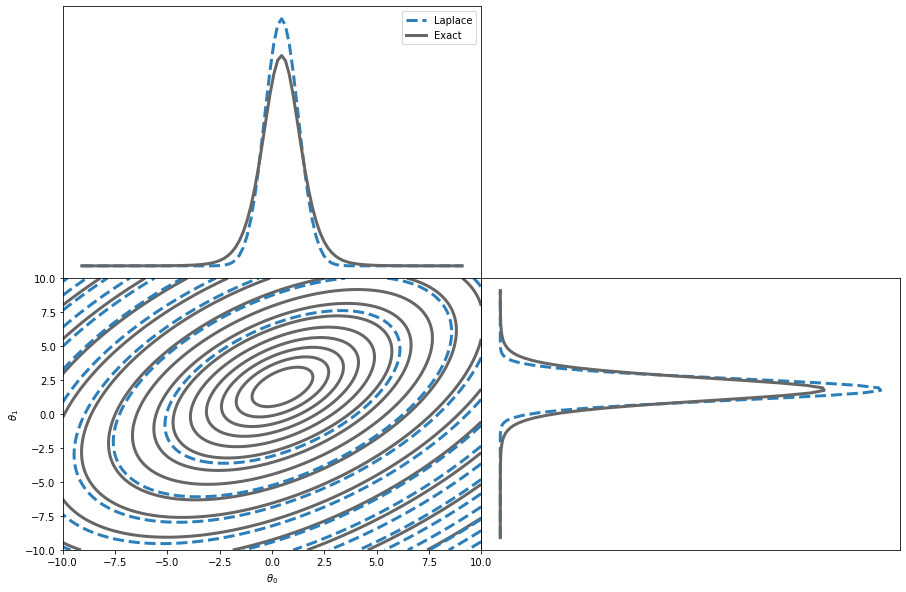

In [10]:
#This is the bigger pice of code jus for visualizing purpose
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
spec = fig.add_gridspec(ncols=2, nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

ax3 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 1])
ax1 = fig.add_subplot(spec[1, 0])

contour = ax1.contour(
    X, Y, Z / Z.max(), colors="0.4", levels=15, linestyles="-", linewidths=3
)

# calculate the density of the approximating Normal distribution
Z_0 = (
    multivariate_normal(mean=theta_star, cov=sigma_approx).logpdf(XY).reshape(100, 100)
)

ax1.contour(
    X, Y, Z_0 / Z_0.max(), colors="#2c7fb8", levels=15, linestyles="--", linewidths=3
)

ax1.set_xlabel(r"$\theta_0$")
ax1.set_ylabel(r"$\theta_1$")

theta_grid=np.linspace(-10, 10, 100)

ax2.plot(
    norm.pdf(theta_grid, theta_star[1], np.sqrt(sigma_approx[1, 1])),
    theta_grid,
    c="#2c7fb8",
    ls="--",
    lw=3,
)
ax2.plot(
    t.pdf(theta_grid, nu[1], mu[1], np.sqrt(sigma[1, 1])), theta_grid, c="0.4", lw=3
)


ax3.plot(
    theta_grid,
    norm.pdf(theta_grid, theta_star[0], np.sqrt(sigma_approx[0, 0])),
    c="#2c7fb8",
    ls="--",
    lw=3,
    label="Laplace",
)
ax3.plot(
    theta_grid,
    t.pdf(theta_grid, nu[0], mu[0], np.sqrt(sigma[0, 0])),
    c="0.4",
    lw=3,
    label="Exact",
)
ax3.legend()

ax2.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)